In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Part I

In [72]:
# SETAR model from Exercise I

N = 1 # length of the time series

# SETAR(l, d, k1, . . . , kl )=SETAR(2;1;1) model with two regimes and one lag in each regime
l = 2  # number of regimes
d = 1  # delay parameter
k = np.array([1, 1]) # number of lags in each regime

tau = 0  # threshold
e = np.random.normal(0, 1, N)


a0 = np.array([-.2, -.4]) # intercepts per regime
a1 = np.array([.7, -.2]) # AR(1) coeffs per regime

X = np.zeros(N)
J = np.zeros(N, dtype=int)
for t in range(1, N):
    j = 0 if X[t - d] <= tau else 1  # regime index (0 or 1)
    J[t] = j
    
    X[t] = a0[j] + a1[j] * X[t - 1] + e[t]  # X_t = a0^(j) + a1^(j) X_{t-1} + e_t

In [73]:
# In a function...

N = 1000
a0 = np.array([-.2, -.4])
a1 = np.array([.7, -.2])
tau = 0
e = np.random.normal(0, 1, N)

# this is a SETAR/(2, d, 1) model
# we have two regimes (l=2), one lag in each regime (k1=k2=1)
def SETAR(d, a0=a0, a1=a1, tau=tau, e=e):
    X = np.zeros(N)
    J = np.zeros(N, dtype=int)
    for t in range(1, N):
        j = 0 if X[t - d] <= tau else 1
        J[t] = j
        X[t] = a0[j] + a1[j]*X[t-1] + e[t]
    return X, J

X, J = SETAR(1, a0, a1, tau, e)

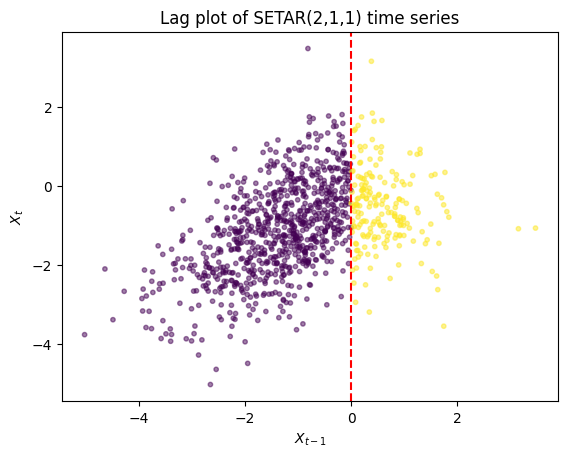

In [74]:
# xs = np.linspace(-3, 3, 1000)
# plt.figure(figsize=(10, 6))
# plt.plot(xs, X)
# plt.title("SETAR(2,1,1) time series")
# plt.legend(["Time Series"])
# plt.show()

plt.scatter(X[:-1], X[1:], alpha=0.5, s=10, c=J[1:]) # color by regime
plt.axvline(tau, color="red", linestyle="--") # threshold line
plt.xlabel("$X_{t-1}$")
plt.ylabel("$X_t$")
plt.title("Lag plot of SETAR(2,1,1) time series")
plt.show()

In [75]:
# Task: Estimate the parameters of the SETAR(2,1,1) model by the prediction error method
# (i.e. conditional least squares).

# section 5.5 p.115

tau = 0
a0 = np.array([-0.2, -0.4])
# x: observed series (1..N). theta0: initial guess

# def one_step_predict(theta, x_prev, a0=a0, tau=tau):
#     # we're going to estimate the a1 parameters only
#     # we predict with a SETAR(2,1, 1) model with known a0 and tau
    
#     # instead of re-running the whole series, we just do one step prediction
#     # theta = [a1L, a1H]; return scalar prediction
#     a1L, a1H = theta
#     if x_prev <= tau: pred = a0[0] + a1L * x_prev
#     else: pred = a0[1] + a1H * x_prev
#     return pred

# vectorised prediction over scalar above
def one_step_predict(theta, x_prev, a0=a0, tau=tau):
    a1L, a1H = theta
    x_prev = x_prev
    
    # boolean masks for regimes (instead of if-else)
    mask_low = x_prev <= tau
    mask_high = ~mask_low
    
    # initialize predictions
    pred = np.empty_like(x_prev)
    pred[mask_low]  = a0[0] + a1L * x_prev[mask_low]
    pred[mask_high] = a0[1] + a1H * x_prev[mask_high]
    
    return pred


def Jac(theta, x, a0=a0, tau=tau):
    N = len(x)
    grad = np.zeros(2)  # [∂Q/∂a1L, ∂Q/∂a1H]
    for t in range(1, N):
        x_prev = x[t-1]
        x_curr = x[t]
        a1L, a1H = theta
        if x_prev <= tau:
            pred = a0[0] + a1L * x_prev
            res = x_curr - pred
            grad[0] += -2 * res * x_prev
        else:
            pred = a0[1] + a1H * x_prev
            res = x_curr - pred
            grad[1] += -2 * res * x_prev
    return grad

def Hessian(theta, x, a0=a0, tau=tau):
    N = len(x)
    H = np.zeros((2, 2))
    for t in range(1, N):
        x_prev = x[t-1]
        if x_prev <= tau:
            H[0, 0] += 2 * x_prev**2
        else:
            H[1, 1] += 2 * x_prev**2
    return H

# defining a loss function Q
def Q(theta, x, a0=a0, tau=tau):
    N = len(x)
    res = np.empty(N-1)
    for j in range(1, N):
        pred = one_step_predict(theta, x[j-1], a0=a0, tau=tau)
        res[j-1] = x[j] - pred
    return float(res @ res) # sum of squared residuals

In [ ]:
# Estimate a1
theta0 = np.array([0.5, -0.2])
res = minimize(Q, x0=theta0, args=(X,), method='Nelder-Mead')
print("True a1:", a1)
print("Estimated a1:", res.x)
print("Success:", res.success, "; Message:", res.message)

True a1: [ 0.7 -0.2]
Estimated a1: [ 0.67728705 -0.25193025]
Success: False ; Message: Desired error not necessarily achieved due to precision loss.


In [77]:
# Estimate a1 with jac and hess info
theta0 = np.array([0.5, -0.2])
res = minimize(Q, x0=theta0, args=(X,), jac=Jac, hess=Hessian, method="Newton-CG")
print("True a1:", a1)
print("Estimated a1:", res.x)
print("Success:", res.success, "; Message:", res.message)

True a1: [ 0.7 -0.2]
Estimated a1: [ 0.67728705 -0.25193031]
Success: True ; Message: Optimization terminated successfully.


# Part II

In [78]:
def Q(theta, x, a0=a0, tau=tau):
    x = np.asarray(x, dtype=float)
    res = x[1:] - one_step_predict(theta, x[:-1], a0=a0, tau=tau)
    return float(res @ res)

In [79]:
grid_size = 100
a1L_vals = np.linspace(-4.0, 4.0, grid_size)
a1H_vals = np.linspace(-4.0, 4.0, grid_size)

Q_grid = np.zeros((grid_size, grid_size))
for i, a1L in enumerate(a1L_vals):
    for j, a1H in enumerate(a1H_vals):
        Q_grid[i, j] = Q([a1L, a1H], x=X, a0=a0, tau=tau)


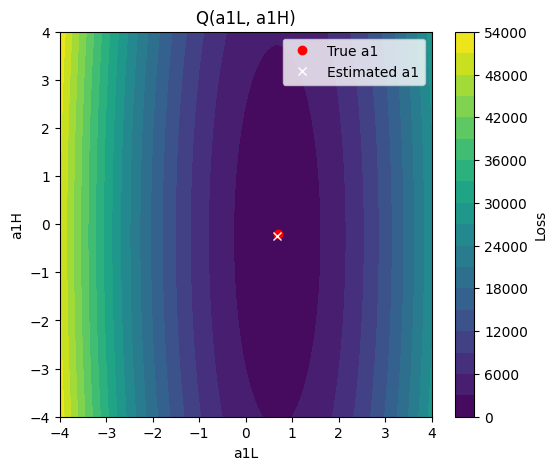

In [80]:
A1L, A1H = np.meshgrid(a1L_vals, a1H_vals, indexing='ij') # make a mesh out of our x and y axes
plt.figure(figsize=(6,5))
cs = plt.contourf(A1L, A1H, Q_grid, levels=20)

plt.title("Q(a1L, a1H)")
plt.plot(a1[0], a1[1], 'ro', label='True a1')  # true parameters
plt.plot(res.x[0], res.x[1], 'wx', label='Estimated a1')  # estimated parameters
plt.legend()
plt.xlabel("a1L")
plt.ylabel("a1H")
plt.colorbar(cs, label="Loss")
plt.show()

In [81]:
grid_size = 100
a1L_vals = np.linspace(0.65, 0.75, grid_size)
a1H_vals = np.linspace(-0.15, -0.25, grid_size)

Q_grid = np.zeros((grid_size, grid_size))
for i, a1L in enumerate(a1L_vals):
    for j, a1H in enumerate(a1H_vals):
        Q_grid[i, j] = Q([a1L, a1H], x=X, a0=a0, tau=tau)


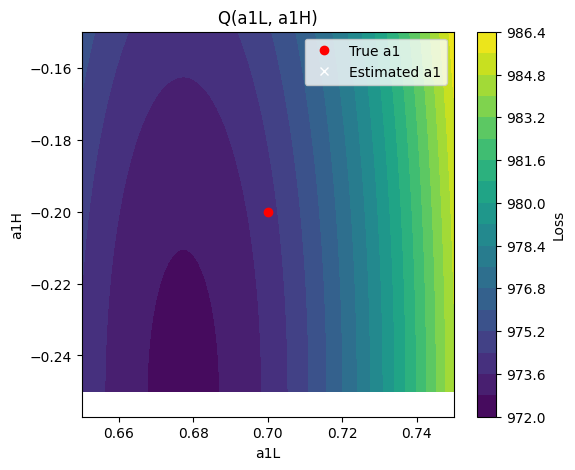

In [82]:
A1L, A1H = np.meshgrid(a1L_vals, a1H_vals, indexing='ij') # make a mesh out of our x and y axes
plt.figure(figsize=(6,5))
cs = plt.contourf(A1L, A1H, Q_grid, levels=20)

plt.title("Q(a1L, a1H)")
plt.plot(a1[0], a1[1], 'ro', label='True a1')  # true parameters
plt.plot(res.x[0], res.x[1], 'wx', label='Estimated a1')  # estimated parameters
plt.legend()
plt.xlabel("a1L")
plt.ylabel("a1H")
plt.colorbar(cs, label="Loss")
plt.show()

# Report

In [83]:
# In a function...

N = 3000
a0 = np.array([-.2, -.4])
a1 = np.array([.7, -.2])
tau = 0
e = np.random.normal(0, 1, N)

# this is a SETAR/(2, d, 1) model
# we have two regimes (l=2), one lag in each regime (k1=k2=1)
def SETAR(d, a0=a0, a1=a1, tau=tau, e=e):
    X = np.zeros(N)
    J = np.zeros(N, dtype=int)
    for t in range(1, N):
        j = 0 if X[t - d] <= tau else 1
        J[t] = j
        X[t] = a0[j] + a1[j]*X[t-1] + e[t]
    return X, J

X, J = SETAR(1, a0, a1, tau, e)

True a1: [ 0.7 -0.2]
Estimated a1: [ 0.69832673 -0.21393543]
Success: True ; Message: Optimization terminated successfully.


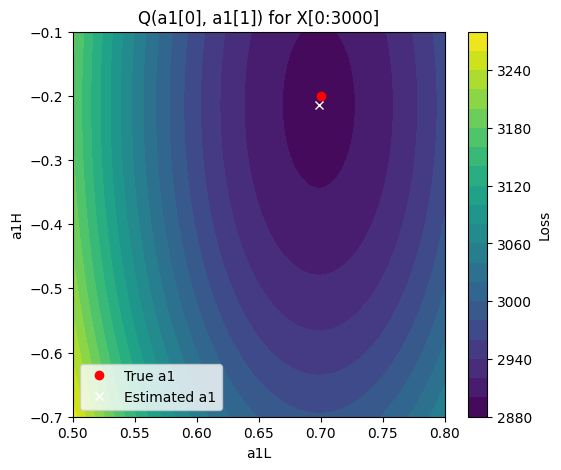

True a1: [ 0.7 -0.2]
Estimated a1: [0.68909003 0.11259509]
Success: True ; Message: Optimization terminated successfully.


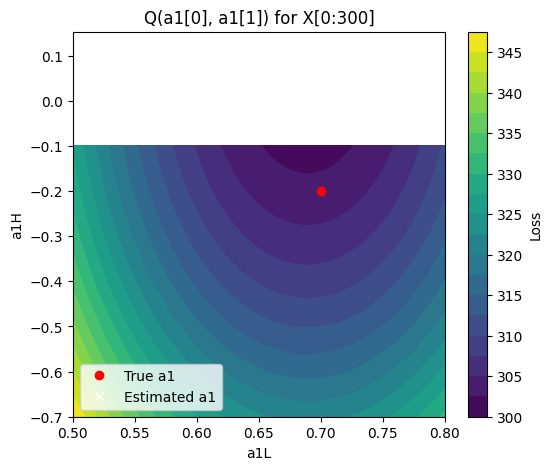

True a1: [ 0.7 -0.2]
Estimated a1: [0.78606358 0.50201982]
Success: True ; Message: Optimization terminated successfully.


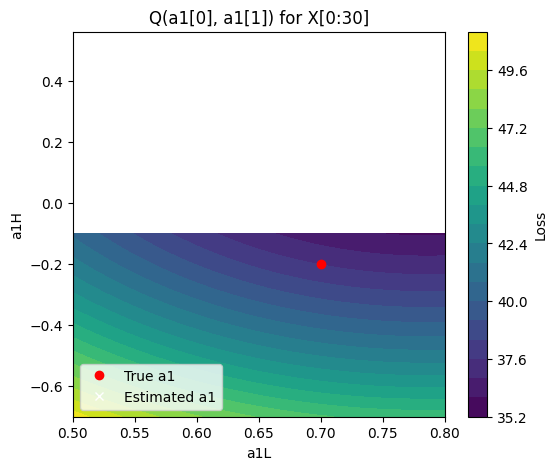

True a1: [ 0.7 -0.2]
Estimated a1: [ 0.68326986 -0.45622866]
Success: True ; Message: Optimization terminated successfully.


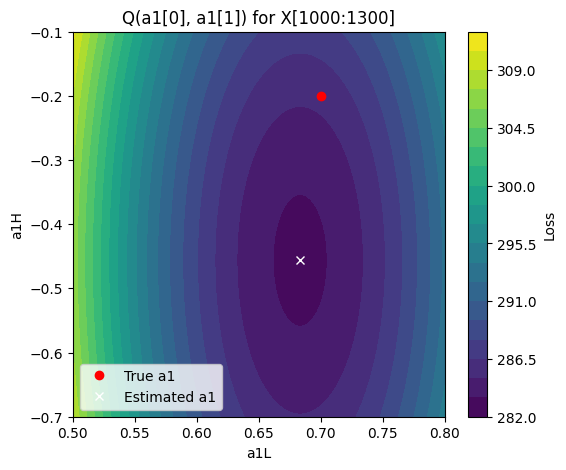

True a1: [ 0.7 -0.2]
Estimated a1: [ 0.69236896 -1.18256769]
Success: True ; Message: Optimization terminated successfully.


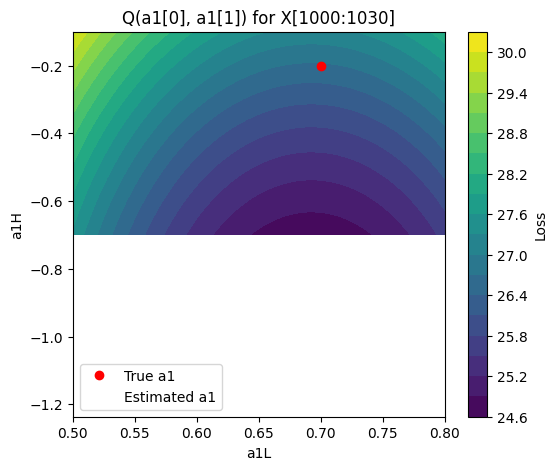

In [84]:
grid_size = 100
a1L_vals = np.linspace(0.5, 0.8, grid_size)
a1H_vals = np.linspace(-.1, -.7, grid_size)

subsets = [slice(0, 3000), slice(0, 300), slice(0, 30), slice(1000, 1300), slice(1000, 1030)]

Q_grids = []

for subset in subsets:
    Q_grid = np.zeros((grid_size, grid_size))
    for i, a1L in enumerate(a1L_vals):
        for j, a1H in enumerate(a1H_vals):
            Q_grid[i, j] = Q([a1L, a1H], x=X[subset], a0=a0, tau=tau)
    
    theta0 = np.array([0.5, -0.2])
    res = minimize(Q, x0=theta0, args=(X[subset],), jac=Jac, hess=Hessian, method="Newton-CG")
    print("True a1:", a1)
    print("Estimated a1:", res.x)
    print("Success:", res.success, "; Message:", res.message)
    
    A1L, A1H = np.meshgrid(a1L_vals, a1H_vals, indexing='ij') # make a mesh out of our x and y axes
    plt.figure(figsize=(6,5))
    cs = plt.contourf(A1L, A1H, Q_grid, levels=20)

    plt.title(f"Q(a1[0], a1[1]) for X[{subset.start}:{subset.stop}]")
    plt.plot(a1[0], a1[1], 'ro', label='True a1')  # true parameters
    plt.plot(res.x[0], res.x[1], 'wx', label='Estimated a1')  # estimated parameters
    # legend bottom left
    plt.legend(loc='lower left')
    plt.xlabel("a1L")
    plt.ylabel("a1H")
    plt.colorbar(cs, label="Loss")
    plt.show()